### **In this notebook we'll be running the exact same process as in the first notebook but, instead of balancing classes with SMOTE, we will drop records from the majority class. As we've already explored the relations between our data, we'll be going straight to the point, for better data visualization and explanations about results check the other notebook**

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import mutual_info_classif, RFE

from imblearn.over_sampling import SMOTE

Proportion of target class 1 against class 0 before downsampling: 0.10397890220073372
Proportion of target class 1 against class 0 after downsampling: 1.0362579693802316


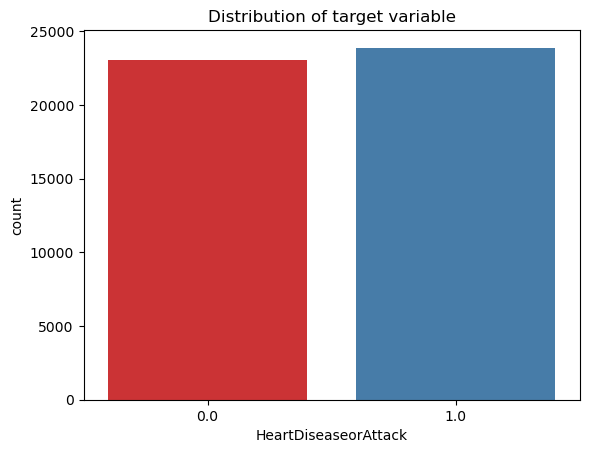

In [3]:
#Load the data
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

print(f"Proportion of target class 1 against class 0 before downsampling: {df[df['HeartDiseaseorAttack'] == 1].shape[0] / df[df['HeartDiseaseorAttack'] == 0].shape[0]}")

indexes = []
for index in df[df['HeartDiseaseorAttack'] == 0].index:
    if np.random.rand() < 0.9:
        indexes.append(index)

df.drop(indexes, inplace=True)

print(f"Proportion of target class 1 against class 0 after downsampling: {df[df['HeartDiseaseorAttack'] == 1].shape[0] / df[df['HeartDiseaseorAttack'] == 0].shape[0]}")

sns.countplot(x=df['HeartDiseaseorAttack'], palette='Set1', hue=df['HeartDiseaseorAttack'], legend=False)
plt.title("Distribution of target variable")
plt.show()


In [4]:
# Separate features and target variable
X = df.drop(columns=['HeartDiseaseorAttack'])
y = df['HeartDiseaseorAttack']

# Normalize the features to avoid bias because of different scales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


In [127]:
# Dictionary to store results
results = {}

# Function to train, evaluate, and store metrics
def train_and_evaluate(model, model_name):
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    end_time = time.time()
    training_time = end_time - start_time

    # Store results in a dictionary
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Training Time (s)': training_time
    }

    # Print the metrics
    print(f"\nPerformance Metrics for {model_name}:\n")
    for metric, value in results[model_name].items():
        print(f"{metric}: {value:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()


Performance Metrics for Logistic Regression:

Accuracy: 0.7703
Precision: 0.7705
Recall: 0.7703
F1 Score: 0.7702
Training Time (s): 0.1793


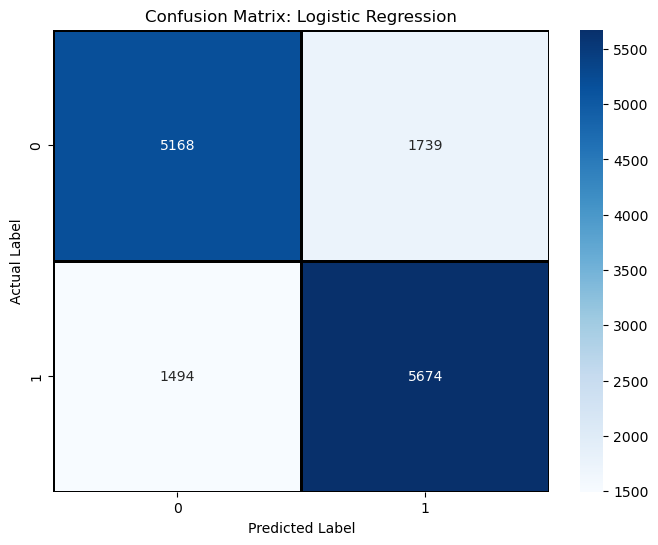


Performance Metrics for k Nearest Neighbors (k-NN):

Accuracy: 0.7277
Precision: 0.7278
Recall: 0.7277
F1 Score: 0.7276
Training Time (s): 0.7715


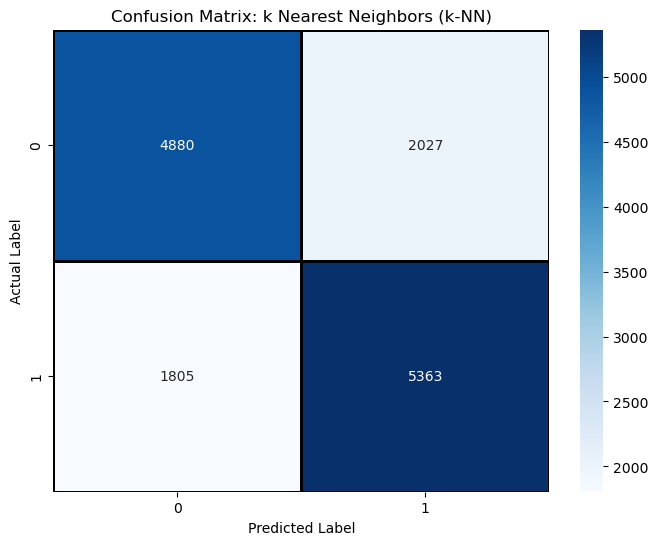


Performance Metrics for Decision Tree:

Accuracy: 0.6760
Precision: 0.6762
Recall: 0.6760
F1 Score: 0.6760
Training Time (s): 0.2121


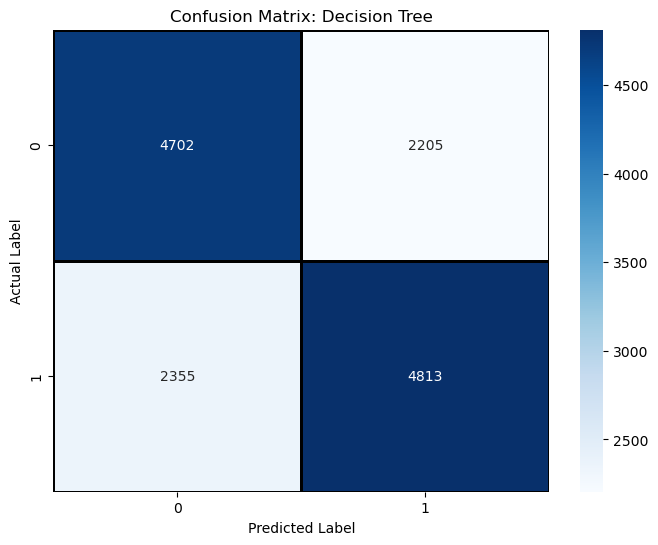


Performance Metrics for Random Forest:

Accuracy: 0.7580
Precision: 0.7587
Recall: 0.7580
F1 Score: 0.7576
Training Time (s): 3.6749


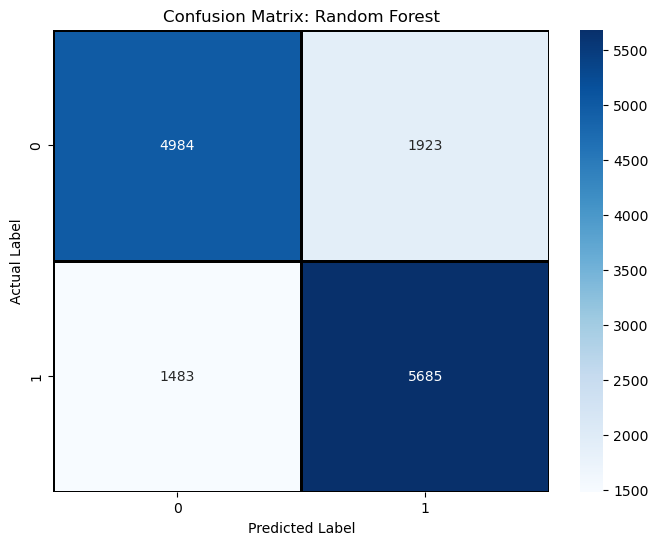

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Performance Metrics for Neural Networks (MLP):

Accuracy: 0.7593
Precision: 0.7602
Recall: 0.7593
F1 Score: 0.7589
Training Time (s): 37.7379


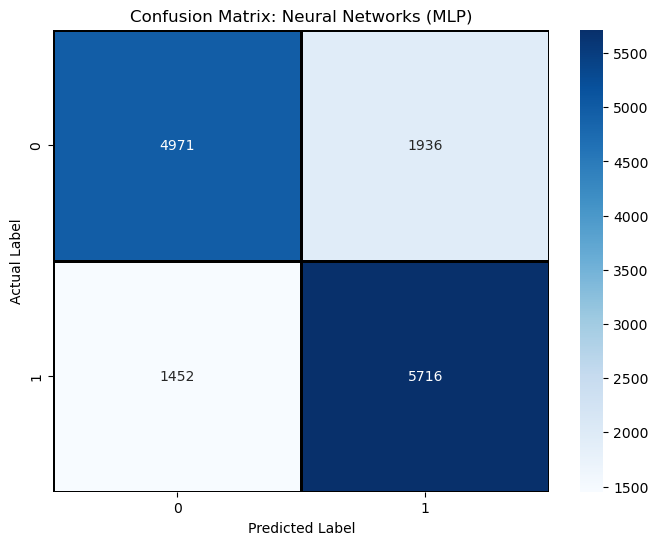

In [128]:
#Train Logistic Regression
logistic_model = LogisticRegression()
train_and_evaluate(logistic_model, "Logistic Regression")

#Train k-Nearest Neighbors
knn_model = KNeighborsClassifier()
train_and_evaluate(knn_model, "k Nearest Neighbors (k-NN)")

#Train Decision Tree
decision_tree_model = DecisionTreeClassifier()
train_and_evaluate(decision_tree_model, "Decision Tree")

#Train Random Forest
random_forest_model = RandomForestClassifier()
train_and_evaluate(random_forest_model, "Random Forest")

#Train Neural Network
neural_network_model = MLPClassifier()
train_and_evaluate(neural_network_model, "Neural Networks (MLP)")

In [129]:
#We will find optimal hyperparameters now with the whole training set as we have much less samples, so it woun't be so inefficient
def tune_hyperparameters(model, param_grid, model_name, cv=5):
    print(f"\n🔍 Tuning hyperparameters for {model_name} using GridSearchCV...")

    # Perform GridSearchCV on the full training set
    grid_search = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Get the best model and hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"\n✅ Best hyperparameters for {model_name}: {best_params}")

    return best_model, best_params


In [130]:
# Logistic Regression
log_reg_params = {
    "C": [0.01, 0.1, 1, 10, 100],  
    "solver": ["liblinear", "lbfgs"]
}
best_log_reg, best_log_reg_params = tune_hyperparameters(LogisticRegression(), log_reg_params, "Logistic Regression", cv=5)

# kNN
knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11],  
    "weights": ["uniform", "distance"],  
    "metric": ["euclidean", "manhattan"]
}
best_knn, best_knn_params = tune_hyperparameters(KNeighborsClassifier(), knn_params, "kNN", cv=5)

# Decision Tree
dt_params = {
    "max_depth": [None, 5, 10, 20],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 5]
}
best_dt, best_dt_params = tune_hyperparameters(DecisionTreeClassifier(), dt_params, "Decision Tree", cv=5)

# Random Forest
rf_params = {
    "n_estimators": [50, 100, 200],  
    "max_depth": [None, 10, 20],  
    "min_samples_split": [2, 5, 10]
}
best_rf, best_rf_params = tune_hyperparameters(RandomForestClassifier(), rf_params, "Random Forest", cv=5)

# Neural Network
nn_params = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],  
    "activation": ["relu", "tanh"],  
    "solver": ["adam", "sgd"],  
    "alpha": [0.0001, 0.001, 0.01]
}
best_nn, best_nn_params = tune_hyperparameters(MLPClassifier(max_iter=500), nn_params, "Neural Network", cv=5)


🔍 Tuning hyperparameters for Logistic Regression using GridSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ Best hyperparameters for Logistic Regression: {'C': 0.01, 'solver': 'lbfgs'}

🔍 Tuning hyperparameters for kNN using GridSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best hyperparameters for kNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

🔍 Tuning hyperparameters for Decision Tree using GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Best hyperparameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

🔍 Tuning hyperparameters for Random Forest using GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

✅ Best hyperparameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

🔍 Tuning hyperparameters for Neural Network using GridSearchCV...
Fitting 5 folds for each of 36 ca

In [131]:
def train_and_evaluate_tuned(model_class, model_name, hyperparameters):
    start_time = time.time()

    # Initialize the model with the best hyperparameters
    model = model_class(**hyperparameters)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    end_time = time.time()
    training_time = end_time - start_time

    # Store results in a dictionary
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Training Time (s)': training_time
    }

    # Print the metrics
    print(f"\nPerformance Metrics for {model_name} (Tuned Hyperparameters):\n")
    for metric, value in results[model_name].items():
        print(f"{metric}: {value:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()



Performance Metrics for Logistic Regression (Tuned Hyperparameters):

Accuracy: 0.7707
Precision: 0.7709
Recall: 0.7707
F1 Score: 0.7706
Training Time (s): 0.1566


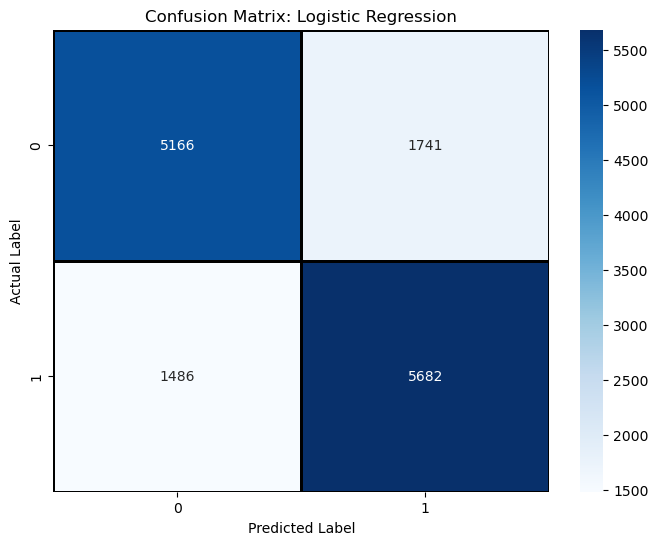


Performance Metrics for k-NN (Tuned Hyperparameters):

Accuracy: 0.7498
Precision: 0.7504
Recall: 0.7498
F1 Score: 0.7495
Training Time (s): 3.1564


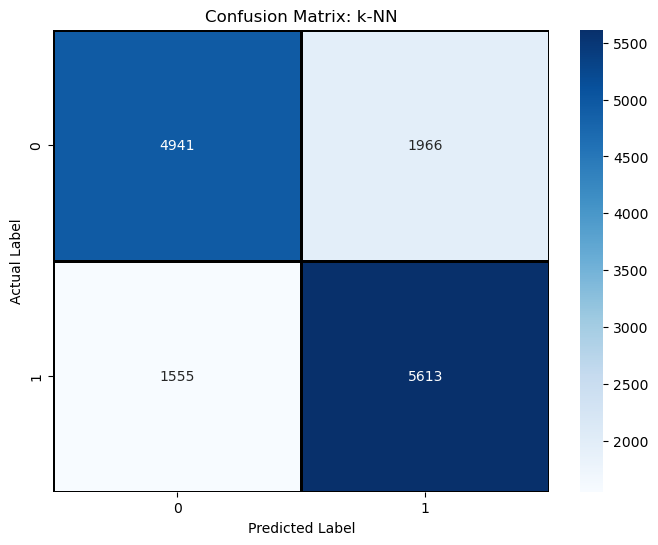


Performance Metrics for Decision Tree (Tuned Hyperparameters):

Accuracy: 0.7513
Precision: 0.7514
Recall: 0.7513
F1 Score: 0.7512
Training Time (s): 0.1566


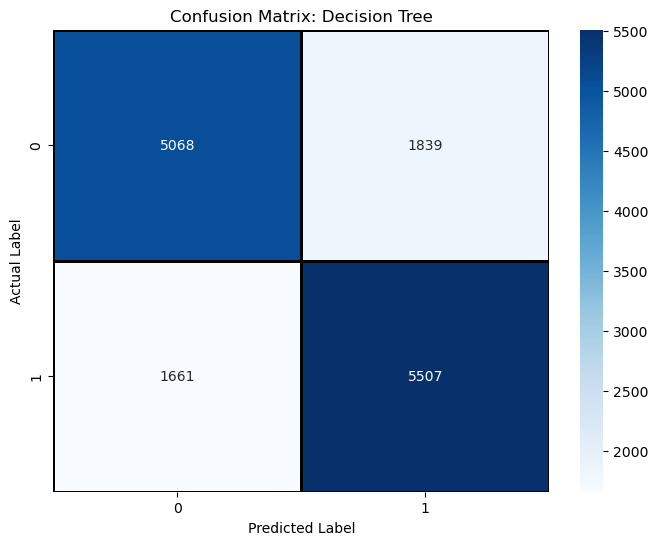


Performance Metrics for Random Forest (Tuned Hyperparameters):

Accuracy: 0.7712
Precision: 0.7732
Recall: 0.7712
F1 Score: 0.7705
Training Time (s): 2.7713


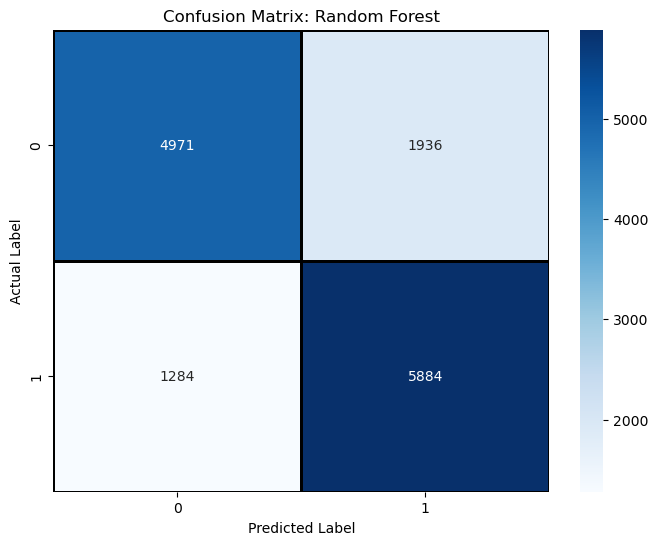


Performance Metrics for Neural Network (Tuned Hyperparameters):

Accuracy: 0.7714
Precision: 0.7727
Recall: 0.7714
F1 Score: 0.7709
Training Time (s): 7.8157


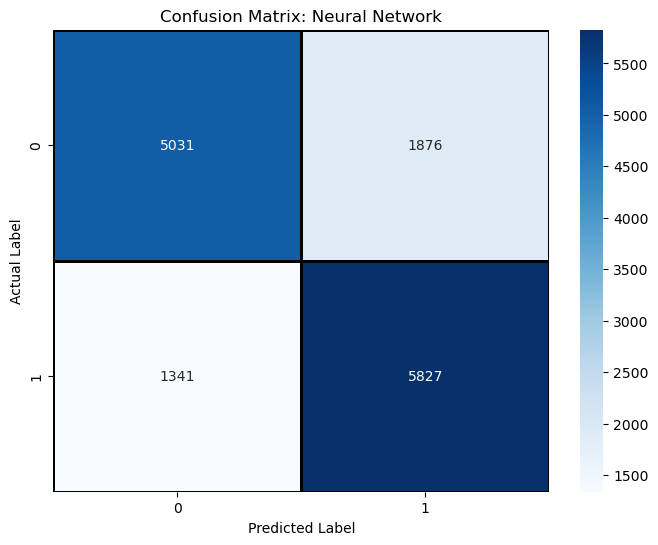

In [132]:
train_and_evaluate_tuned(LogisticRegression, "Logistic Regression", best_log_reg_params)

train_and_evaluate_tuned(KNeighborsClassifier, "k-NN", best_knn_params)

train_and_evaluate_tuned(DecisionTreeClassifier, "Decision Tree", best_dt_params)

train_and_evaluate_tuned(RandomForestClassifier, "Random Forest", best_rf_params)

train_and_evaluate_tuned(MLPClassifier, "Neural Network", best_nn_params)



Performance Metrics for Voting Classifier (Hard):

Accuracy: 0.7713
Precision: 0.7713
Recall: 0.7713
F1 Score: 0.7712
Training Time (s): 11.2967


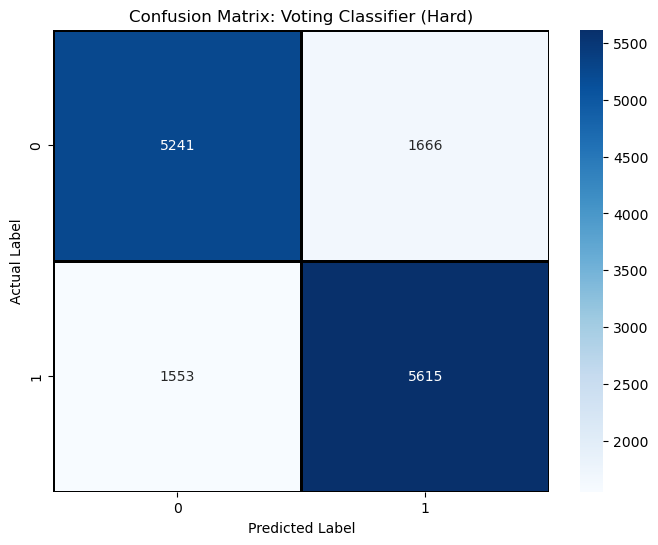

In [133]:

# Define the base models with their best hyperparameters
knn_best = KNeighborsClassifier(**best_knn_params)
dt_best = DecisionTreeClassifier(**best_dt_params)
log_reg_best = LogisticRegression(**best_log_reg_params)
nn_best = MLPClassifier(**best_nn_params)

# Hard Voting: Majority Class Prediction
voting_hard = VotingClassifier(
    estimators=[
        ('kNN', knn_best),
        ('Decision Tree', dt_best),
        ('Logistic Regression', log_reg_best),
        ('Neural Network', nn_best)
    ],
    voting='hard'  # 'hard' for majority vote, 'soft' for probability averaging
)

# Train & Evaluate
train_and_evaluate(voting_hard, "Voting Classifier (Hard)")

In [5]:
mi_scores = mutual_info_classif(X, y)
mi_features = np.argsort(mi_scores)[::-1]  # Sort in descending order

# Initialize Random Forest with a lower number of estimators for efficiency
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

# Initialize RFE (removes 5 features at a time for efficiency)
rfe_selector = RFE(rf, n_features_to_select=1, step=5)

rfe_selector.fit(X, y)

# Get ranking of features (lower rank = more important)
rfe_ranking = rfe_selector.ranking_

# Store features in order of importance
rfe_features = np.array(X.columns)[np.argsort(rfe_ranking)]

In [ ]:
print(f"Features in order of importance (RFE): {rfe_features}")
print(f"Features in order of importance (MI): {X.columns[mi_features]}")

Features in order of importance (RFE): ['BMI' 'Income' 'Age' 'PhysHlth' 'GenHlth' 'Education' 'Sex' 'DiffWalk'
 'MentHlth' 'HighBP' 'HighChol' 'Fruits' 'PhysActivity' 'Diabetes'
 'Stroke' 'Smoker' 'AnyHealthcare' 'NoDocbcCost' 'CholCheck' 'Veggies'
 'HvyAlcoholConsump']
Mutual Information Scores: Index(['GenHlth', 'Age', 'HighBP', 'DiffWalk', 'HighChol', 'PhysHlth',
       'Diabetes', 'Stroke', 'Income', 'Smoker', 'Sex', 'Education',
       'PhysActivity', 'Veggies', 'CholCheck', 'AnyHealthcare', 'MentHlth',
       'BMI', 'Fruits', 'NoDocbcCost', 'HvyAlcoholConsump'],
      dtype='object')


In [136]:
# Function to train, plot learning curve, and find best features
def train_with_feature_selection(model, model_name, feature_set, feature_type, n_features_max=10,hyperparams=None):
    accuracies = []
    best_acc = 0
    best_n_features = 1
    best_features = []
    best_model = None

    print(f"\n🔹 Training {model_name} using {feature_type} features...")
    X_train_df = pd.DataFrame(X_train, columns=X.columns)
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    # Try training with 1 to 10 most important features
    for k in range(1, n_features_max+1):
        
        if feature_type == 'RFE':
            selected_features = list(feature_set[:k])  # ✅ Ensure it's a list of feature names
        else:
            selected_features = list(X.columns[feature_set][:k])  # ✅ Ensure it's a list of feature names
        
        X_train_subset = X_train_df[selected_features]  # Select columns by feature names        
        # ✅ Convert X_test to DataFrame to allow column-based indexing
        X_test_subset = pd.DataFrame(X_test, columns=X_train_df.columns)[selected_features]

        # Apply hyperparameters if provided
        if hyperparams:
            model.set_params(**hyperparams)

        start_time = time.time()

        # Train model
        model.fit(X_train_subset, y_train)
        y_pred = model.predict(X_test_subset)

        end_time = time.time()
        training_time = end_time - start_time

        # Evaluate accuracy
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        # Keep track of the best performing model
        if acc > best_acc:
            best_acc = acc
            best_n_features = k
            best_features = selected_features
            best_model = model

    # Plot learning curve
    plt.plot(range(1, n_features_max+1), accuracies, marker='o', linestyle='-')
    plt.xlabel("Number of Features")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve: {model_name} ({feature_type})")
    plt.show()

    # Evaluate and display results for the best model
    best_model.fit(X_train_df[best_features], y_train)
    y_pred_best = best_model.predict(X_test_df[best_features])

    print(f"\n✅ Best Model for {model_name} ({feature_type}): {best_n_features} Features")
    print(f"📌 Selected Features: {best_features}")

    # Store and print final metrics
    results = {
        'Accuracy': accuracy_score(y_test, y_pred_best),
        'Precision': precision_score(y_test, y_pred_best, average='weighted'),
        'Recall': recall_score(y_test, y_pred_best, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred_best, average='weighted')
    }

    print("\n📊 Final Metrics:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    print("\n⏱️ Training Time (s):", training_time)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(f'Confusion Matrix: {model_name} ({feature_type})')
    plt.show()


🔹 Training Logistic Regression using RFE features...


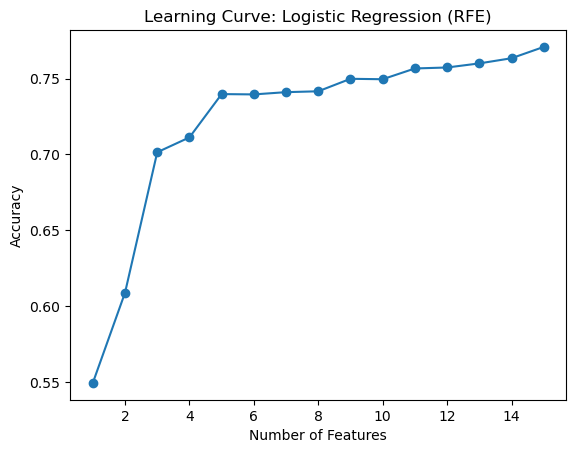


✅ Best Model for Logistic Regression (RFE): 15 Features
📌 Selected Features: ['BMI', 'Income', 'Age', 'PhysHlth', 'GenHlth', 'Education', 'DiffWalk', 'MentHlth', 'HighBP', 'Diabetes', 'HighChol', 'PhysActivity', 'Stroke', 'Smoker', 'Sex']

📊 Final Metrics:
Accuracy: 0.7709
Precision: 0.7711
Recall: 0.7709
F1 Score: 0.7708

⏱️ Training Time (s): 0.03801369667053223


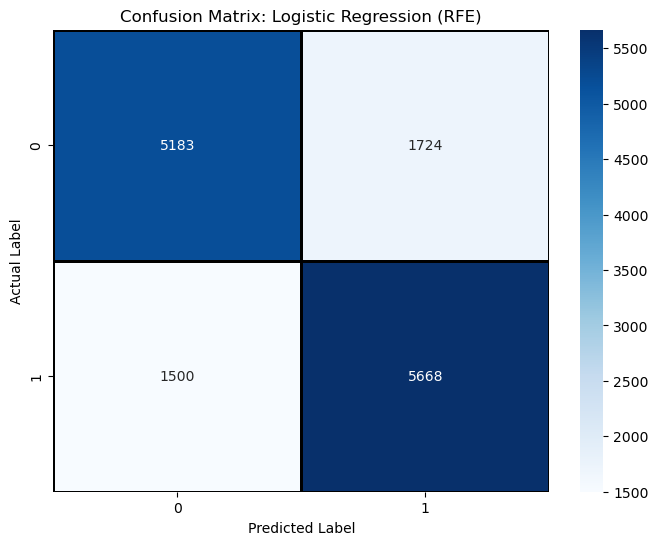


🔹 Training Logistic Regression using MI features...


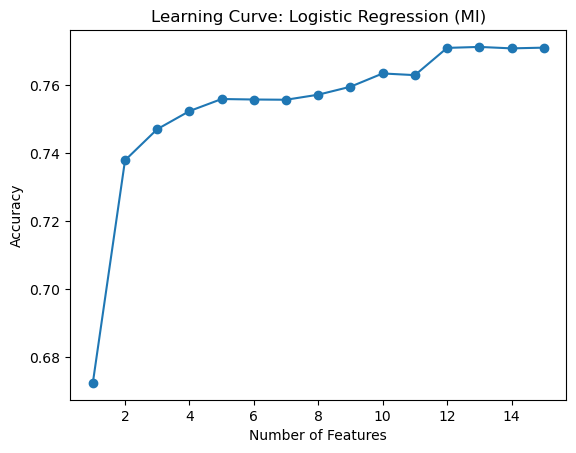


✅ Best Model for Logistic Regression (MI): 13 Features
📌 Selected Features: ['Age', 'GenHlth', 'HighBP', 'HighChol', 'DiffWalk', 'Diabetes', 'PhysHlth', 'Income', 'Stroke', 'Smoker', 'PhysActivity', 'Sex', 'Veggies']

📊 Final Metrics:
Accuracy: 0.7713
Precision: 0.7715
Recall: 0.7713
F1 Score: 0.7712

⏱️ Training Time (s): 0.030145645141601562


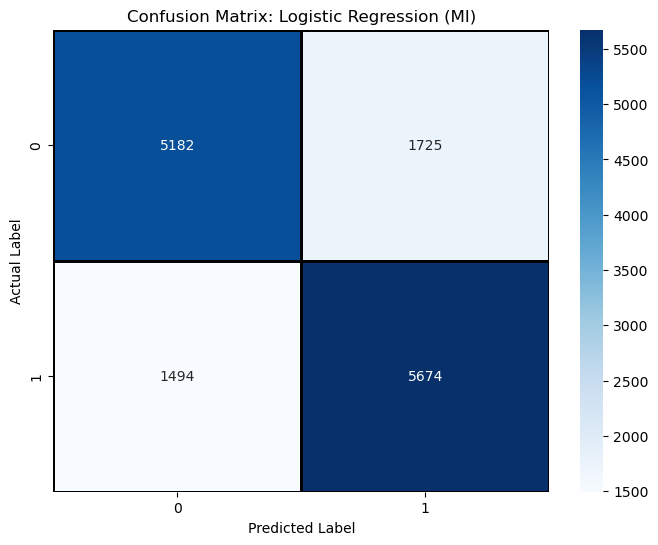


🔹 Training k-NN using RFE features...


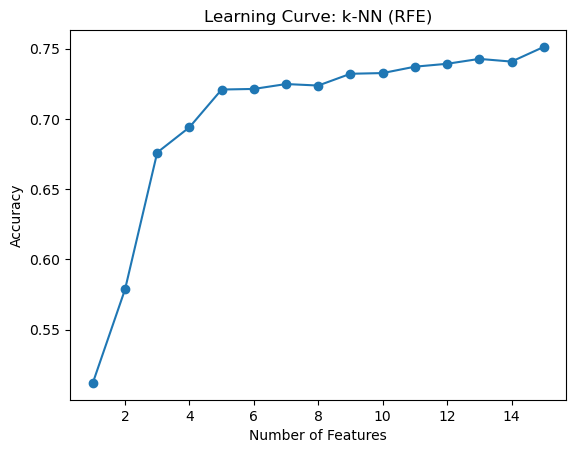


✅ Best Model for k-NN (RFE): 15 Features
📌 Selected Features: ['BMI', 'Income', 'Age', 'PhysHlth', 'GenHlth', 'Education', 'DiffWalk', 'MentHlth', 'HighBP', 'Diabetes', 'HighChol', 'PhysActivity', 'Stroke', 'Smoker', 'Sex']

📊 Final Metrics:
Accuracy: 0.7512
Precision: 0.7517
Recall: 0.7512
F1 Score: 0.7509

⏱️ Training Time (s): 14.48480749130249


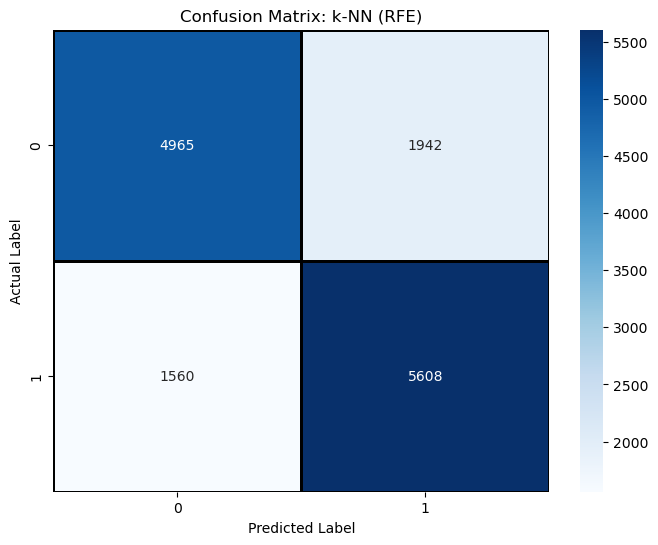


🔹 Training k-NN using MI features...


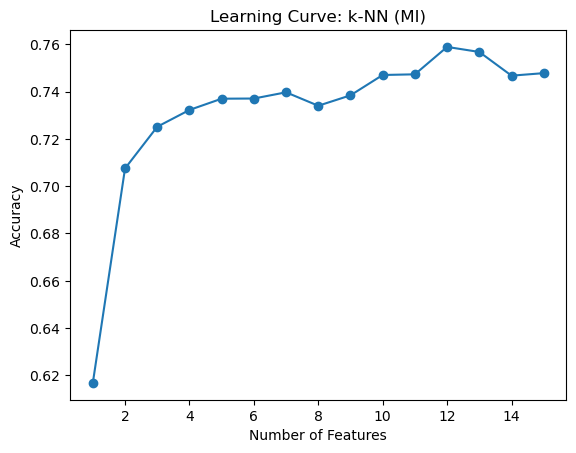


✅ Best Model for k-NN (MI): 12 Features
📌 Selected Features: ['Age', 'GenHlth', 'HighBP', 'HighChol', 'DiffWalk', 'Diabetes', 'PhysHlth', 'Income', 'Stroke', 'Smoker', 'PhysActivity', 'Sex']

📊 Final Metrics:
Accuracy: 0.7589
Precision: 0.7596
Recall: 0.7589
F1 Score: 0.7585

⏱️ Training Time (s): 25.050514221191406


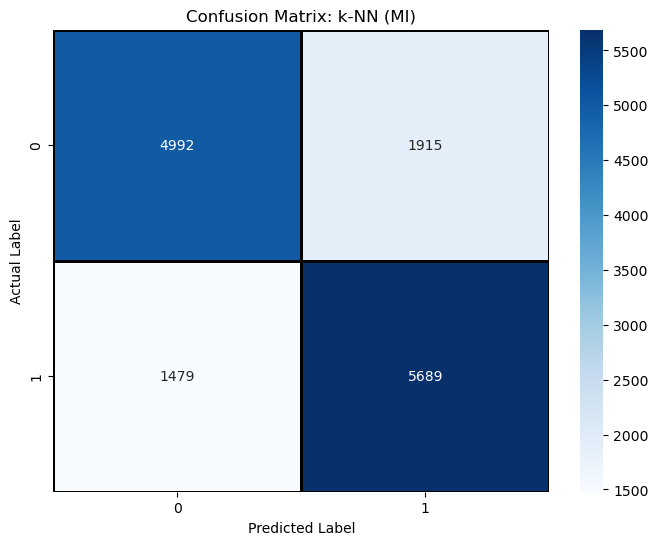


🔹 Training Decision Tree using RFE features...


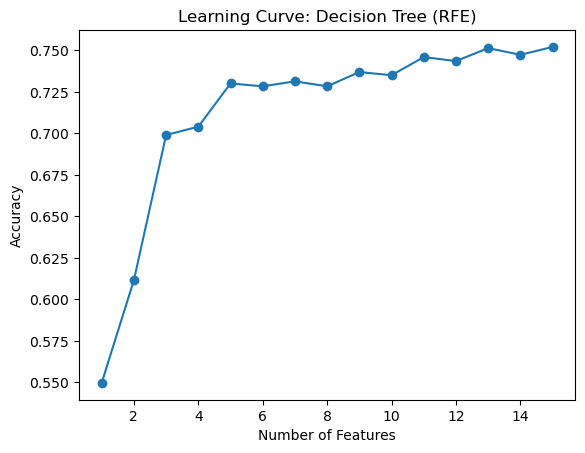


✅ Best Model for Decision Tree (RFE): 15 Features
📌 Selected Features: ['BMI', 'Income', 'Age', 'PhysHlth', 'GenHlth', 'Education', 'DiffWalk', 'MentHlth', 'HighBP', 'Diabetes', 'HighChol', 'PhysActivity', 'Stroke', 'Smoker', 'Sex']

📊 Final Metrics:
Accuracy: 0.7525
Precision: 0.7529
Recall: 0.7525
F1 Score: 0.7523

⏱️ Training Time (s): 0.2046666145324707


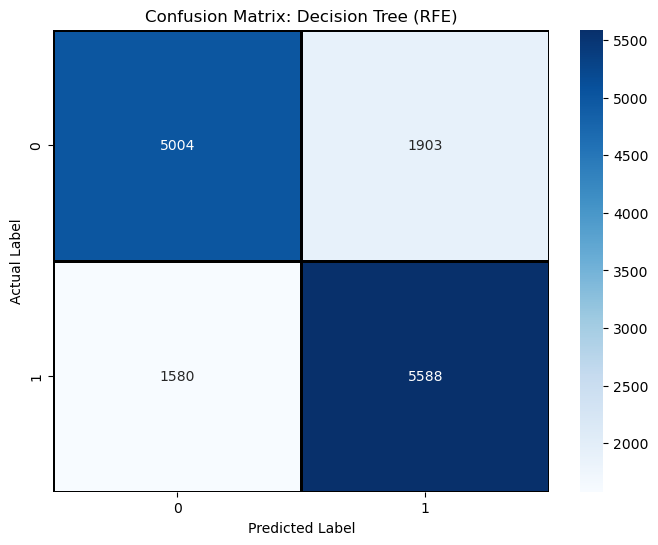


🔹 Training Decision Tree using MI features...


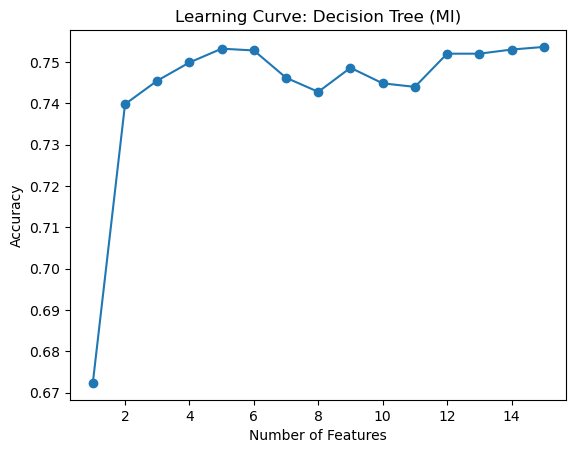


✅ Best Model for Decision Tree (MI): 15 Features
📌 Selected Features: ['Age', 'GenHlth', 'HighBP', 'HighChol', 'DiffWalk', 'Diabetes', 'PhysHlth', 'Income', 'Stroke', 'Smoker', 'PhysActivity', 'Sex', 'Veggies', 'Education', 'CholCheck']

📊 Final Metrics:
Accuracy: 0.7537
Precision: 0.7538
Recall: 0.7537
F1 Score: 0.7535

⏱️ Training Time (s): 0.17316746711730957


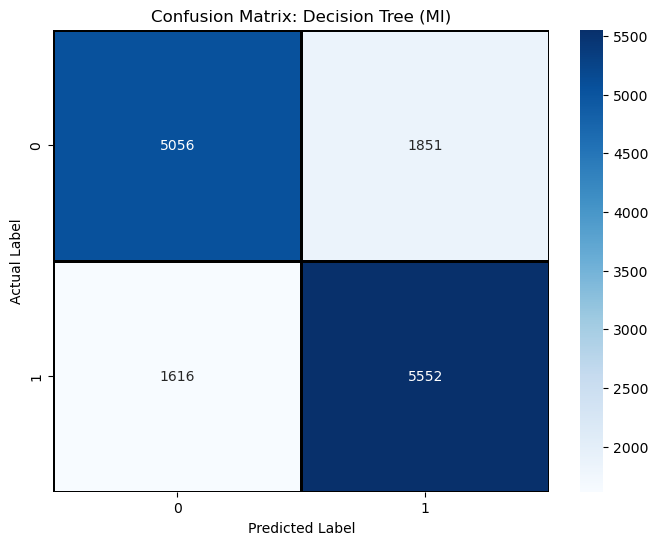


🔹 Training Random Forest using RFE features...


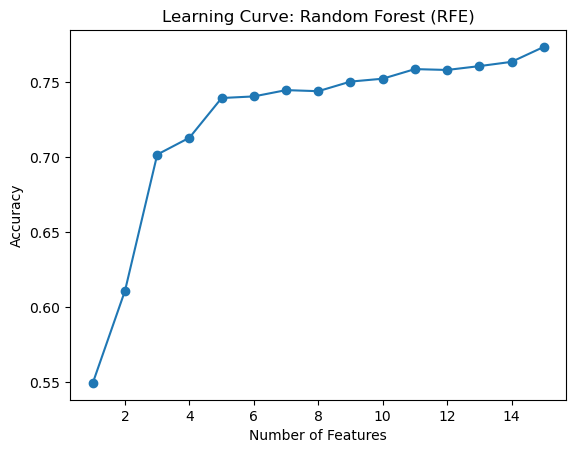


✅ Best Model for Random Forest (RFE): 15 Features
📌 Selected Features: ['BMI', 'Income', 'Age', 'PhysHlth', 'GenHlth', 'Education', 'DiffWalk', 'MentHlth', 'HighBP', 'Diabetes', 'HighChol', 'PhysActivity', 'Stroke', 'Smoker', 'Sex']

📊 Final Metrics:
Accuracy: 0.7722
Precision: 0.7739
Recall: 0.7722
F1 Score: 0.7716

⏱️ Training Time (s): 2.5178263187408447


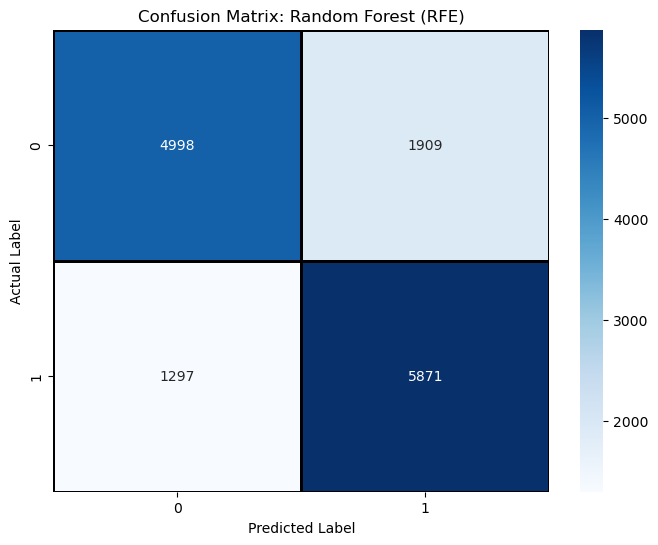


🔹 Training Random Forest using MI features...


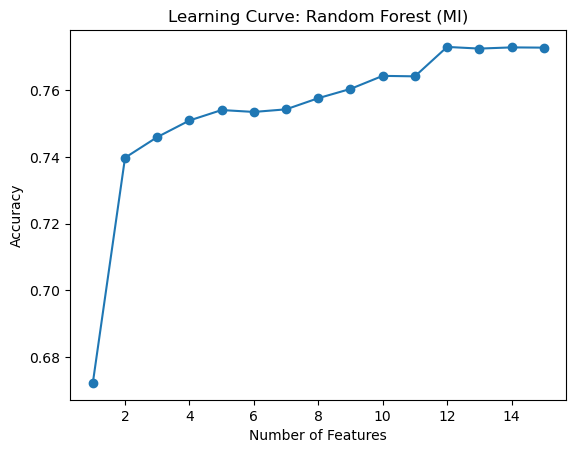


✅ Best Model for Random Forest (MI): 12 Features
📌 Selected Features: ['Age', 'GenHlth', 'HighBP', 'HighChol', 'DiffWalk', 'Diabetes', 'PhysHlth', 'Income', 'Stroke', 'Smoker', 'PhysActivity', 'Sex']

📊 Final Metrics:
Accuracy: 0.7719
Precision: 0.7737
Recall: 0.7719
F1 Score: 0.7713

⏱️ Training Time (s): 4.5889387130737305


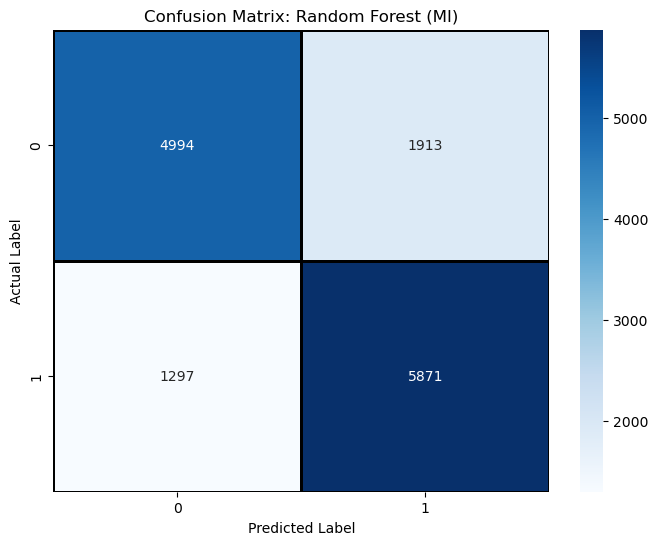


🔹 Training Neural Network using RFE features...


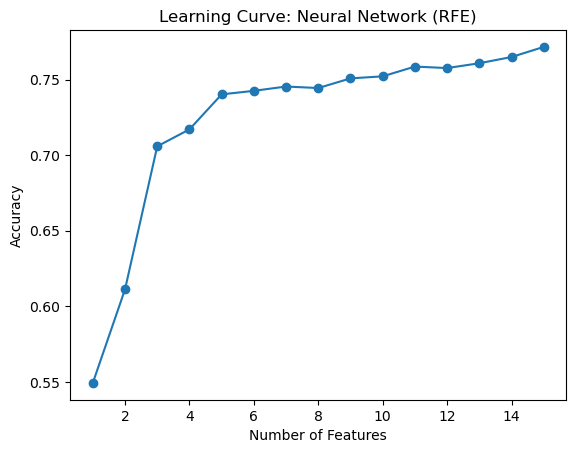


✅ Best Model for Neural Network (RFE): 15 Features
📌 Selected Features: ['BMI', 'Income', 'Age', 'PhysHlth', 'GenHlth', 'Education', 'DiffWalk', 'MentHlth', 'HighBP', 'Diabetes', 'HighChol', 'PhysActivity', 'Stroke', 'Smoker', 'Sex']

📊 Final Metrics:
Accuracy: 0.7717
Precision: 0.7732
Recall: 0.7717
F1 Score: 0.7712

⏱️ Training Time (s): 14.485033988952637


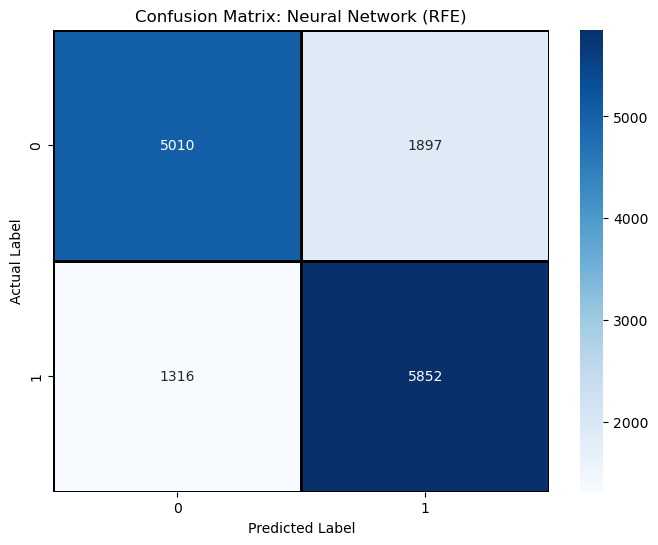


🔹 Training Neural Network using MI features...


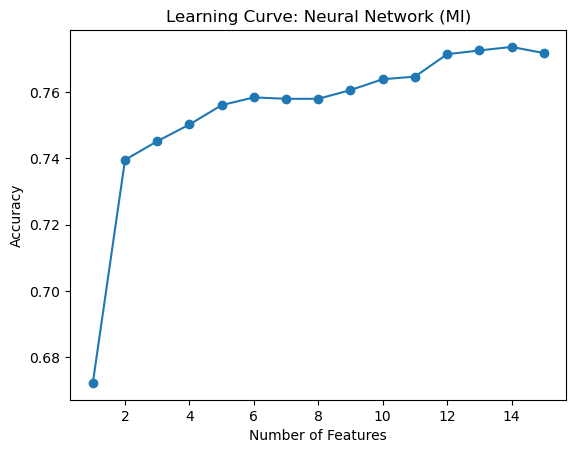


✅ Best Model for Neural Network (MI): 14 Features
📌 Selected Features: ['Age', 'GenHlth', 'HighBP', 'HighChol', 'DiffWalk', 'Diabetes', 'PhysHlth', 'Income', 'Stroke', 'Smoker', 'PhysActivity', 'Sex', 'Veggies', 'Education']

📊 Final Metrics:
Accuracy: 0.7721
Precision: 0.7735
Recall: 0.7721
F1 Score: 0.7716

⏱️ Training Time (s): 10.271775960922241


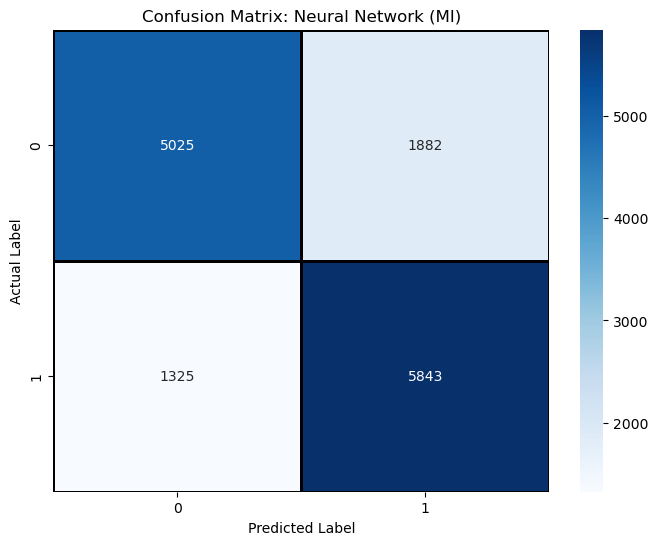

In [137]:
train_with_feature_selection(LogisticRegression(), "Logistic Regression", rfe_features, "RFE", 15, best_log_reg_params)
train_with_feature_selection(LogisticRegression(), "Logistic Regression", mi_features, "MI", 15, best_log_reg_params)

train_with_feature_selection(KNeighborsClassifier(), "k-NN", rfe_features, "RFE", 15, best_knn_params)
train_with_feature_selection(KNeighborsClassifier(), "k-NN", mi_features, "MI", 15, best_knn_params)

train_with_feature_selection(DecisionTreeClassifier(), "Decision Tree", rfe_features, "RFE", 15, best_dt_params)
train_with_feature_selection(DecisionTreeClassifier(), "Decision Tree", mi_features, "MI", 15, best_dt_params)

train_with_feature_selection(RandomForestClassifier(), "Random Forest", rfe_features, "RFE", 15, best_rf_params)
train_with_feature_selection(RandomForestClassifier(), "Random Forest", mi_features, "MI", 15, best_rf_params)

train_with_feature_selection(MLPClassifier(), "Neural Network", rfe_features, "RFE", 15, best_nn_params)
train_with_feature_selection(MLPClassifier(), "Neural Network", mi_features, "MI", 15, best_nn_params)

